In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np

## Metrik

Als Metrik wurde eine angepasste Version der Root Mean Squared Percentage Error (RMSPE)-Funktion implementiert. Um mathematische Probleme bei der Berechnung zu vermeiden, werden Datenpunkte mit Verkaufszahlen von null ignoriert, da eine Division durch null zu fehlerhaften Ergebnissen führen würde. Die Funktion berechnet den prozentualen Fehler nur für relevante Datenpunkte und liefert somit eine präzise Einschätzung der Modellgüte. Zusätzlich wird RMSPE als Scoring-Funktion mittels make_scorer in scikit-learn definiert, wobei geringere Werte auf eine bessere Modellleistung hinweisen.

In [4]:

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [5]:
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Daten einlesen

Der Datensatz wird mit pd.read_csv() aus der Datei geladen. Dabei werden Kommata als Trennzeichen, Latein-1 als Encoding, sowie Tausender- und Dezimaltrennzeichen korrekt verarbeitet. low_memory=False stellt sicher, dass der Datensatz in einem Schritt eingelesen wird.

In [6]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

## Features

Die Zeitmerkmale Jahr, Monat, Tag und Woche des Jahres helfen dabei, saisonale Trends und zeitabhängige Muster zu erfassen. Verkäufe variieren häufig in bestimmten Monaten oder Jahreszeiten, was die Vorhersagegenauigkeit deutlich erhöht. Die Verwendung von Fourier-Transformationen, speziell die Fourier-Sin- und Fourier-Cos-Funktionen für 365 Tage, ermöglicht es, saisonale Effekte auf kontinuierliche Weise zu modellieren. Diese Features sind besonders nützlich, um komplexe saisonale Muster zu identifizieren und verbessern die Robustheit der Vorhersagen.
Die Merkmale `days_since_last_holiday` und `days_until_next_holiday` `wurden gewählt, da Feiertage oft einen signifikanten Einfluss auf die Verkaufszahlen haben. Diese zeitlichen Angaben helfen dem Modell, den Einfluss von Feiertagen auf den Verkauf in den relevanten Zeiträumen zu erfassen.

`Promo` und `Promo2` geben an, ob während bestimmter Zeiträume Werbeaktionen durchgeführt werden. Promotionen haben häufig einen erheblichen Einfluss auf die Verkaufszahlen, und die Berücksichtigung dieser Merkmale ermöglicht es dem Modell, den Effekt von Rabatten auf die Verkaufsprognosen zu lernen.

Verkaufszahlen variieren oft an verschiedenen Wochentagen, und die Codierung des Features `day_of_the_week` erlaubt es dem Modell, wöchentliche Muster zu erkennen. Das `StoreType`-Feature ist relevant, da die Art des Geschäfts einen Einfluss auf die Verkaufszahlen haben kann. Unterschiedliche Geschäftsmodelle ziehen unterschiedliche Kunden an und verfolgen variierende Verkaufsstrategien.

Ein weiteres wichtiges Feature ist `StateHoliday`, das angibt, ob ein Feiertag vorliegt. Feiertage haben oft einen starken Einfluss auf den Einzelhandel, und das Modell kann lernen, diese Effekte zu berücksichtigen. Das `Assortment`-Feature, das die Produktvielfalt im Geschäft beschreibt, ist ebenfalls entscheidend, da unterschiedliche Sortimentstypen verschiedene Kunden anziehen und die Verkaufszahlen beeinflussen können. Schließlich liefert das `Store`-Feature Informationen über spezifische Geschäfte, was hilft, lokale Verkaufsunterschiede zu erfassen. Jedes Geschäft kann unterschiedliche Verkaufsleistungen aufweisen, die durch Faktoren wie Lage, Größe und Zielgruppe bedingt sind.

In [7]:
# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Open', 'Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store'] 

## Split

Der folgende Code beschreibt die Aufteilung der Daten in einen Trainings- und Testdatensatz zur Vorbereitung für maschinelles Lernen. Zunächst wird der Datensatz anhand der Spalte „Date“ sortiert, um sicherzustellen, dass die zeitliche Reihenfolge der Datenpunkte korrekt ist. Dies ist  notwendig,da es sich um eine Zeitreihenanalyse handelt, bei der die Reihenfolge der Daten für die Genauigkeit der Vorhersage entscheidend ist.

Zusätzlich werden alle Einträge, bei denen der Store geschlossen war (Open == 0) oder bei denen keine Verkäufe (Sales > 0) stattfanden, aus dem Datensatz entfernt. Diese Filterung sorgt dafür, dass das Modell nur auf den relevanten Daten trainiert wird, bei denen der Store tatsächlich offen war und Verkäufe getätigt wurden. Dies verbessert die Qualität der Daten und reduziert das Risiko von Fehlprognosen aufgrund irrelevanter oder fehlender Werte.

Im nächsten Schritt wird die Zielvariable „Sales“ festgelegt. Sie wird separat als y definiert, da sie die zu prognostizierenden Werte enthält. Gleichzeitig werden die Spalten „Sales“ und „Date“ aus den Features (X) entfernt, da „Sales“ die Zielgröße ist und „Date“ in diesem Kontext keine erklärende Variable darstellt. Dies hilft, das Modell auf die relevanten Merkmale des Datensatzes zu reduzieren.

Zuletzt erfolgt die Aufteilung des Datensatzes in Trainings- und Testdaten. Die ersten 80 % der Daten werden für das Training des Modells verwendet, während die letzten 20 % als Testdaten reserviert werden, um das Modell auf noch nicht gesehenen Daten zu evaluieren. Dieser Ansatz, bei dem die Testdaten aus den letzten Datenpunkten bestehen, ist besonders sinnvoll für zeitbasierte Modelle, da zukünftige Werte auf Grundlage vergangener Ereignisse vorhergesagt werden sollen. Die folgende Abbildung visualisiert diesen Split.

Quellen: Mulla(n.d.), Sharma(2020)

In [8]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

# auch noch Text hinzufügen
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales',  'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']

# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

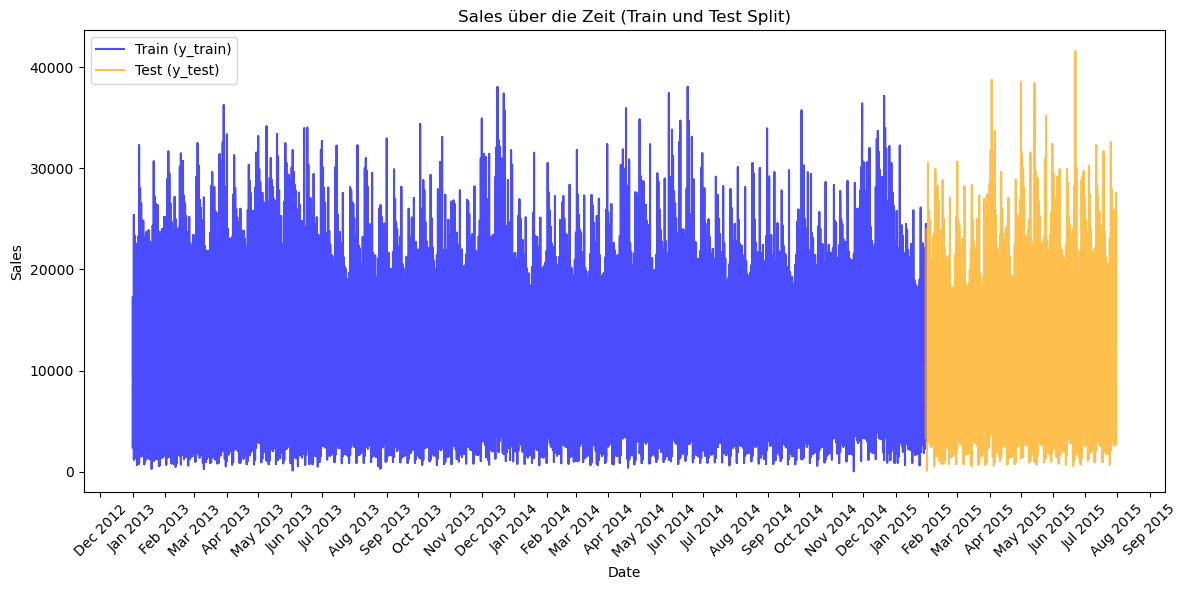

In [9]:
# Konvertiere die 'Date'-Spalte in datetime mit der .loc Methode
X_train.loc[:, 'Date'] = pd.to_datetime(X_train['Date'], errors='coerce')
X_test.loc[:, 'Date'] = pd.to_datetime(X_test['Date'], errors='coerce')

# Liniendiagramm erstellen, um die wahren Sales in y_train und y_test zu visualisieren
plt.figure(figsize=(12, 6))

# Plot für die Trainingsdaten (y_train)
plt.plot(X_train['Date'], y_train, label='Train (y_train)', color='blue', alpha=0.7)

# Plot für die Testdaten (y_test)
plt.plot(X_test['Date'], y_test, label='Test (y_test)', color='orange', alpha=0.7)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales über die Zeit (Train und Test Split)')

# X-Achse mit Datumsformatierung (Monat und Jahr)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Drehe die x-Achsenbeschriftung für bessere Lesbarkeit

# Legende
plt.legend()

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

## TimeSeries Kreuzvalidierung

Als Kreuzvalidierungsmethode wurde ein TimeSeriesSplit aus der Bibliothek scikit-learn implementiert. Dies gewährleistet, dass die zeitliche Abfolge der Daten gewahrt bleibt, indem der Datensatz in aufeinanderfolgende Trainings- und Test-Splits unterteilt wird. So wird das Modell nur auf Vergangenheitsdaten trainiert und auf zukünftigen Daten evaluiert, was notwendig für Zeitreihendaten ist. Den Abbildungen ist zu entnehmen, dass die Anzahl an Trainingsdaten mit jedem Fold zunimmt und so das Verhältnis zwischen Trainings- und Validierungsdatensatz sich jeweils unterscheidet.

Quellen: Shrivastava(2020), Scikit-learn developers(a)

In [10]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

<Figure size 600x400 with 0 Axes>

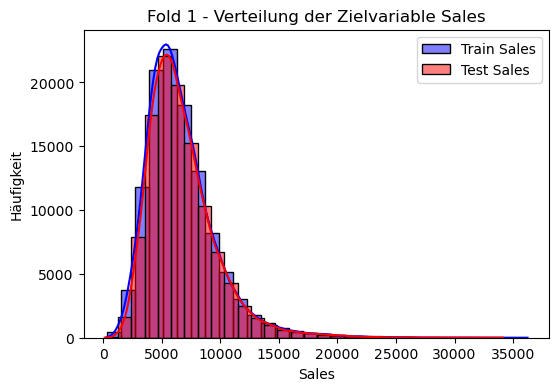

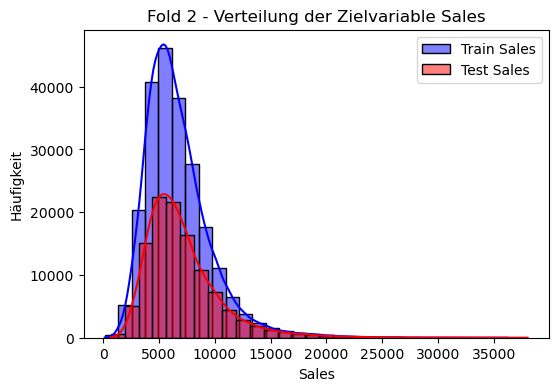

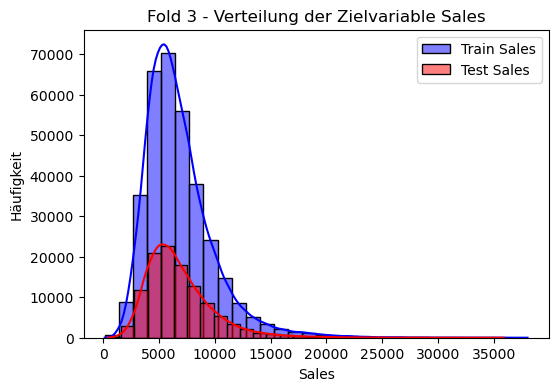

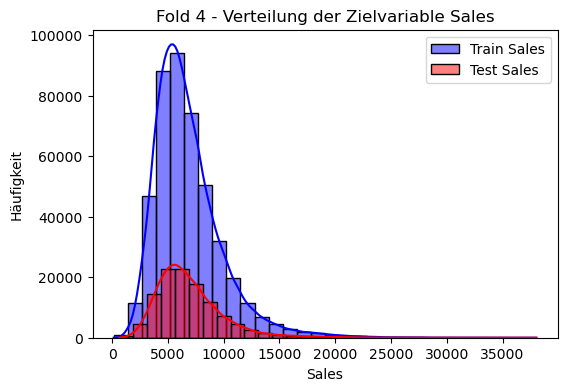

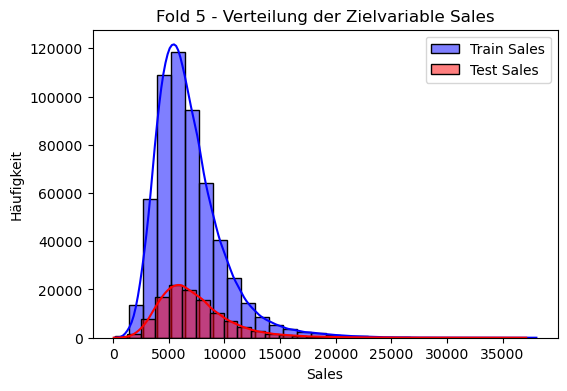

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

# Zeitbasierte Cross-Validation initialisieren
tscv = TimeSeriesSplit(n_splits=5)

# Erstellen einer Liste für die Verteilung der Zielvariable
sales_in_folds = []

# Schleife über die Folds, um die Trainings- und Test-Zielwerte zu extrahieren
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    train_sales = y_train.iloc[train_index]  # Extrahiere die Zielwerte der Trainingsdaten
    test_sales = y_train.iloc[test_index]    # Extrahiere die Zielwerte der Testdaten
    
    # Speichere die Zielwerte für die Visualisierung
    sales_in_folds.append((train_sales, test_sales))

# Visualisierung der Verteilung der Zielvariable "Sales" als Histogramm für jeden Fold
plt.figure(figsize=(6, 4))
for fold_idx, (train_sales, test_sales) in enumerate(sales_in_folds):
    plt.figure(figsize=(6, 4))
    
    # Histogramm für Trainings-Sales
    sns.histplot(train_sales, color='blue', kde=True, label='Train Sales', bins=30)
    
    # Histogramm für Test-Sales
    sns.histplot(test_sales, color='red', kde=True, label='Test Sales', bins=30)
    
    # Beschriftungen und Titel
    plt.title(f'Fold {fold_idx + 1} - Verteilung der Zielvariable Sales')
    plt.xlabel('Sales')
    plt.ylabel('Häufigkeit')
    plt.legend()
    plt.show()

## Pre-Processing

Im Preprocessing wird ein ColumnTransformer verwendet, um numerische, bereits encodierte und noch nicht encodierte kategoriale Merkmale eines Datensatzes gezielt zu transformieren. Dieser Schritt ist essenziell, um eine konsistente und effektive Vorbereitung der Daten zu gewährleisten.

Die numerischen Merkmale, die in der Liste numerical_features enthalten sind, umfassen Variablen wie year, month, day, week_of_year, sowie Lag-Features (lag_1, lag_7, lag_30), Fourier-Transformationen zur Erfassung saisonaler Zyklen und Variablen zur Berücksichtigung von Feiertagen. Diese werden mit dem StandardScaler standardisiert, um sicherzustellen, dass alle numerischen Werte auf einen einheitlichen Maßstab gebracht werden.

Bereits One-Hot-encodierte Merkmale (already_encoded_features) wie Open, Promo und promo2 werden ohne weitere Transformation mit 'passthrough' durchgeschleust. Diese Variablen wurden entweder schon in vorherigen Schritten in eine geeignete Form gebracht oder bedürfen keiner weiteren Skalierung oder Encodierung.

Die noch nicht encodierten kategorialen Merkmale, wie DayOfWeek, StoreType, StateHoliday und Assortment, werden mittels OneHotEncoder in binäre Merkmale umgewandelt. Dies gewährleistet, dass jedes Merkmal durch eine Reihe von Spalten dargestellt wird, die angeben, ob eine bestimmte Kategorie vorliegt. Um potenziell unbekannte Kategorien in den Testdaten zu berücksichtigen, wird die Option handle_unknown='ignore' verwendet, wodurch unbekannte Werte ignoriert werden, ohne einen Fehler zu verursachen.

Durch diesen modularen Ansatz werden die numerischen und kategorialen Features des Datensatzes effizient für das Training des Machine-Learning-Modells vorbereitet.

Quelle: Scikit-learn developers(b)

In [ ]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

## Quellen

Mulla. (n.d.). Tutorial: Time series forecasting with XGBoost [Notebook]. Kaggle. Retrieved September 23, 2024, from https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook

Scikit-learn developers. (a). sklearn.model_selection.TimeSeriesSplit. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

Scikit-learn developers. (b). sklearn.preprocessing. Scikit-learn. Retrieved September 23, 2024, from https://scikit-learn.org/stable/api/sklearn.preprocessing.html

Sharma. (2020, January 4). XGBoost for time series forecasting. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/

Shrivastava. (2020, January 14). Cross-validation in time series. Medium. https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4